In [65]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import os


In [66]:
#create list of teams as shown in url and as shown in table
atl10_teams_url = ['massachusetts','duquesne','st-bonaventure','loyola-il','george-mason','dayton','george-washington',
                'rhode-island','richmond','saint-josephs','saint-louis','virginia-commonwealth','la-salle','fordham','davidson']

atl10_teams = ['UMass','Duquesne','St. Bonaventure','Loyola (IL)','George Mason','Dayton','George Washington','Rhode Island','Richmond',
               'St. Joseph\'s','Saint Louis','VCU','La Salle','Fordham','Davidson']

In [67]:
#read csv if it exists to save time
if os.path.exists('Atlantic10-2024-gamelogs.csv'):
    atl10_df = pd.read_csv('Atlantic10-2024-gamelogs.csv', index_col=0)

else:
    
    #create conference dataframe
    atl10_df = pd.DataFrame()

    #loop through teams, reading each table and concatinating it with our dataframe
    for index, team in enumerate(atl10_teams_url):

        #create url for lookup
        url = f'http://www.sports-reference.com/cbb/schools/{team}/men/2024-gamelogs.html'

        #read table from html
        df = pd.read_html(url, header=1, attrs={'id': 'sgl-basic_NCAAM'})[0]

        #create team name column and insert it in index 3
        df.insert(loc=3, column='Team', value=atl10_teams[index])
        
        #concatenate team dataframe with conference dataframe
        atl10_df = pd.concat([atl10_df, df], ignore_index=True)

        #sleep to avoid error 429: too many requests
        time.sleep(random.randint(4,6))
    
    #write to csv so we don't have to wait a minute everytime we reload the data   
    atl10_df.to_csv('Atlantic10-2024-gamelogs.csv')

In [68]:
#drop non-conference games
atl10_df = atl10_df[atl10_df['Opp'].isin(atl10_teams)]

In [69]:
#reset index after removing rows
atl10_df.reset_index(drop=True, inplace=True)

In [70]:
#rename unnamed column to Home/Away and modify column to show H for Home, A for Away, and N for Neutral
atl10_df = atl10_df.rename(columns={'Unnamed: 2' : 'H/A'})

atl10_df['H/A'] = atl10_df['H/A'].apply(lambda x: 'Away' if x == '@' else 'Neutral' if x == 'N' else 'Home')

In [71]:
#rename all columns with .1 to show that it is the opponents stats
atl10_df = atl10_df.rename(columns={col: 'Opp_' + col[:-2] for col in atl10_df.columns if '.1' in col})

#rename points columns
atl10_df = atl10_df.rename(columns={'Tm':'Pts', 'Opp_Opp' : 'Opp_Pts'})

In [72]:
#drop empty colum 23
atl10_df = atl10_df.drop(columns='Unnamed: 23')

In [73]:
#change date type from object to datetime
atl10_df['Date'] = pd.to_datetime(atl10_df['Date'], format='%Y-%m-%d')

In [74]:
#change types of percentage columns from object to float
atl10_df = atl10_df.apply(lambda x: x.astype(float) if x.name.endswith('%') else x)

In [75]:
#change stat types from object to int
object_cols = ['Date','H/A','Opp','W/L','Team']
atl10_df = atl10_df.apply(lambda x: x.astype(int) if x.name not in object_cols and not x.name.endswith('%') else x)

In [77]:
#create and calculate possessions column for both team and opponent
atl10_df['Pos'] = round(.96 * (atl10_df['FGA'] + atl10_df['TOV'] + .44 * atl10_df['FTA'] - atl10_df['ORB']), 1)

atl10_df['Opp_Pos'] = round(.96 * (atl10_df['Opp_FGA'] + atl10_df['Opp_TOV'] + .44 * atl10_df['Opp_FTA'] - atl10_df['Opp_ORB']), 1)

In [81]:
#use possessions colum to calculate offensive and defensive efficiency for each game
atl10_df['OER'] = round(100 * atl10_df['Pts'] / atl10_df['Pos'], 1)

atl10_df['DER'] = round(100 * atl10_df['Opp_Pts'] / atl10_df['Opp_Pos'], 1)

In [203]:
#create df that holds team name and effeciency ratings
Team_ER = atl10_df.groupby('Team')[['OER','DER','Pos']].mean().reset_index()

In [204]:
#explore effeciency ratings
Team_ER.sort_values('OER', ascending=False)

,Team,OER,DER,Pos
1,Dayton,119.036842,104.189474,62.857895
12,St. Joseph's,113.280952,111.780952,65.457143
11,St. Bonaventure,113.142857,111.276190,64.533333
13,UMass,112.136842,108.105263,65.300000
10,Saint Louis,112.060000,121.865000,67.475000
4,George Mason,110.815789,107.605263,61.489474
9,Richmond,110.726316,102.536842,63.463158
14,VCU,110.431818,105.368182,63.245455
5,George Washington,109.131579,119.936842,67.742105
7,Loyola (IL),108.447368,100.431579,67.500000


In [205]:
#explore effeciency ratings
Team_ER.sort_values('DER', ascending=True)

,Team,OER,DER,Pos
7,Loyola (IL),108.447368,100.431579,67.500000
9,Richmond,110.726316,102.536842,63.463158
2,Duquesne,105.422727,102.913636,63.813636
1,Dayton,119.036842,104.189474,62.857895
14,VCU,110.431818,105.368182,63.245455
0,Davidson,104.684211,106.815789,65.200000
4,George Mason,110.815789,107.605263,61.489474
13,UMass,112.136842,108.105263,65.300000
3,Fordham,103.575000,109.670000,66.200000
11,St. Bonaventure,113.142857,111.276190,64.533333


In [206]:
#explore possessions
Team_ER.sort_values('Pos', ascending=False)

,Team,OER,DER,Pos
5,George Washington,109.131579,119.936842,67.742105
7,Loyola (IL),108.447368,100.431579,67.500000
10,Saint Louis,112.060000,121.865000,67.475000
8,Rhode Island,107.947368,119.536842,67.084211
3,Fordham,103.575000,109.670000,66.200000
6,La Salle,105.095000,114.140000,65.945000
12,St. Joseph's,113.280952,111.780952,65.457143
13,UMass,112.136842,108.105263,65.300000
0,Davidson,104.684211,106.815789,65.200000
11,St. Bonaventure,113.142857,111.276190,64.533333


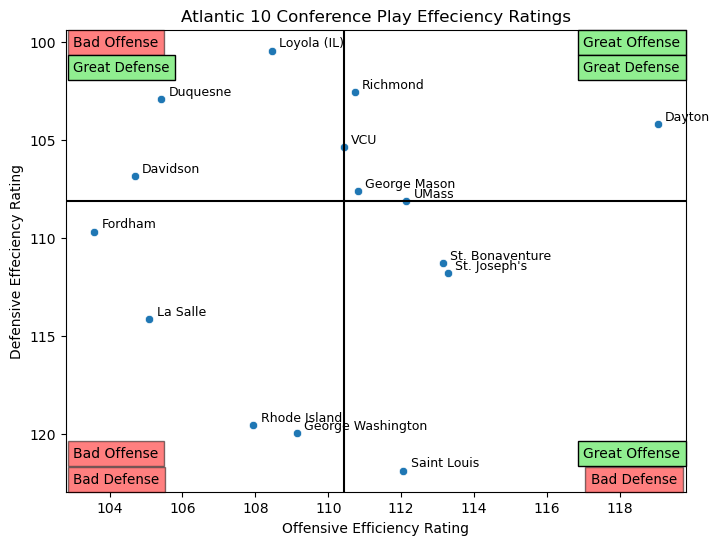

In [208]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=Team_ER, x='OER', y='DER')

for i in range(Team_ER.shape[0]):
    plt.text(Team_ER['OER'][i] + .2, Team_ER['DER'][i] - .2, Team_ER['Team'][i], fontsize=9)

plt.xlabel('Offensive Efficiency Rating')
plt.ylabel('Defensive Effeciency Rating')
plt.title('Atlantic 10 Conference Play Effeciency Ratings')

plt.gca().invert_yaxis()

median_oer = Team_ER['OER'].median()
median_der = Team_ER['DER'].median()

plt.axvline(x=median_oer, color='black')
plt.axhline(y=median_der, color='black')

plt.text(117, 100.2,'Great Offense',fontsize = 10,bbox = dict(facecolor = 'lightgreen'))
plt.text(117, 101.5,'Great Defense',fontsize = 9.6,bbox = dict(facecolor = 'lightgreen'))

plt.text(103, 100.2,'Bad Offense',fontsize = 10,bbox = dict(facecolor = 'red',alpha=.5))
plt.text(103, 101.5,'Great Defense',fontsize = 9.6,bbox = dict(facecolor = 'lightgreen'))

plt.text(103, 121.2,'Bad Offense',fontsize = 10,bbox = dict(facecolor = 'red', alpha=.5))
plt.text(103, 122.5,'Bad Defense',fontsize = 9.7,bbox = dict(facecolor = 'red', alpha=.5))

plt.text(117, 121.2,'Great Offense',fontsize = 10,bbox = dict(facecolor = 'lightgreen'))
plt.text(117.2, 122.5,'Bad Defense',fontsize = 9.7,bbox = dict(facecolor = 'red', alpha=.5))

plt.show()

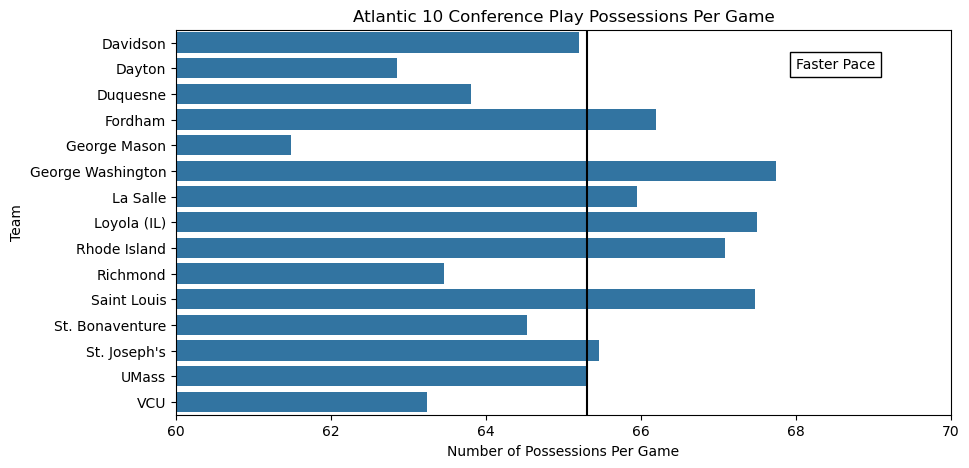

In [209]:
plt.figure(figsize=(10,5))
sns.barplot(data=Team_ER, x='Pos', y='Team')

plt.xlabel('Number of Possessions Per Game')
plt.ylabel('Team')
plt.title('Atlantic 10 Conference Play Possessions Per Game')

plt.xlim(60, 70)

median_pos = Team_ER['Pos'].median()
plt.axvline(x=median_pos, color='black')

plt.text(68, 'Dayton','Faster Pace',fontsize = 10,bbox = dict(facecolor='white'))

plt.show()

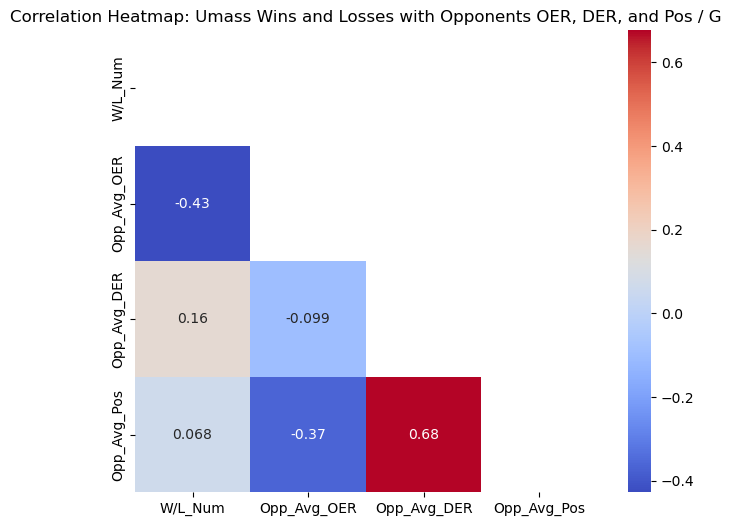

In [216]:
#want to find correlation between umass wins and losses and opponents Offense, Defense, and Pace to show what they struggle and thrive against
umass_df = pd.merge(atl10_df[(atl10_df['Team'] == 'UMass')], 
         Team_ER.rename(columns={'Team':'Opp','OER':'Opp_Avg_OER','DER':'Opp_Avg_DER','Pos':'Opp_Avg_Pos'}), on='Opp')

#convert W to 1 and L to 0 to show correlation
umass_df['W/L_Num'] = umass_df['W/L'].apply(lambda x: 1 if x == 'W' else 0)

corr_matrix = umass_df[['W/L_Num','Opp_Avg_OER','Opp_Avg_DER','Opp_Avg_Pos']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            square=True, mask=mask)

plt.title('Correlation Heatmap: Umass Wins and Losses with Opponents OER, DER, and Pos / G')
plt.show()
